In [1]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
#%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [2]:
import os
print(os.environ["LD_LIBRARY_PATH"])

$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, models, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, TimeDistributed, LSTM, SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam

In [15]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-11-04 10:58:41.137756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:41.138023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:41.138369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:41.138574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:41.138819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [16]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read the csv dataset to get the values for stage and discharge of the images

In [17]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [19]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df.head()

,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,2.99,916.0,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,2.99,916.0,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,2.96,873.0,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,2.94,846.0,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,2.94,846.0,2012-06-09 15:45:00,2012


In [20]:
df = df.sort_values(by="SensorTime", ascending=True)
df.head()

,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,2.99,916.0,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,2.99,916.0,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,2.96,873.0,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,2.94,846.0,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,2.94,846.0,2012-06-09 15:45:00,2012


### Remove outliers

In [21]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

We consider values equal to 0 as outliers because from the photos it doesn't seem that it would be possible that at this time we would have a value of 0 for stage or discharge

In [22]:
df.shape

(40148, 5)

### Scale the data

In [23]:
from sklearn.preprocessing import StandardScaler
from joblib import load

scaler = StandardScaler()
#scaler = load('std_scaler.joblib') # scaler with all the 42059 observations

Scale the data based only on the training dataset (in this case the training dataset is from 2012 to 2016)

In [24]:
data_to_scale_fit = df[(df["Year"] >= 2012) & (df["Year"] <= 2016)][["Stage", "Discharge"]]
data_to_scale_fit

,Discharge
0,916.0
1,916.0
2,873.0
3,846.0
4,846.0
...,...
21416,279.0
21417,279.0
21418,279.0
21419,279.0


In [25]:
scaler.fit(data_to_scale_fit)


StandardScaler()

In [ ]:
from joblib import dump
#dump(scaler, 'std_scaler_train_value_0_outliers.joblib')

In [26]:
df[["Stage", "Discharge"]] = scaler.transform(df[["Stage", "Discharge"]])
df

,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,2.99,-0.136077,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,2.99,-0.136077,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,2.96,-0.165451,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,2.94,-0.183894,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,2.94,-0.183894,2012-06-09 15:45:00,2012
...,...,...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,2.54,-0.465332,2019-10-11 09:00:00,2019
42055,StateLineWeir_20191011_Farrell_410.jpg,2.54,-0.465332,2019-10-11 10:00:00,2019
42056,StateLineWeir_20191011_Farrell_411.jpg,2.54,-0.465332,2019-10-11 11:00:00,2019
42057,StateLineWeir_20191011_Farrell_412.jpg,2.54,-0.465332,2019-10-11 12:00:00,2019


## Create the dataset pipeline

In [28]:
IMG_SIZE = 224
#IMG_SIZE = 512
BATCH_SIZE = 32
FRAMES = 10

In [29]:
from dataset_transformer import make_dataset

In [30]:
path = "../../dataset/images_tmp_draw"

with tf.device("/gpu:0"):
    train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, BATCH_SIZE, IMG_SIZE, FRAMES, df, 10, True, "cnn")

2022-11-04 10:58:42.520654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:42.520923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:42.521069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:42.521277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 10:58:42.521428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

20304
7117
12727


In [31]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

(32, 224, 224, 3)
(32, 1)


In [32]:
print(input_shape)
print(output_shape)

(224, 224, 3)
(1,)


## Check images

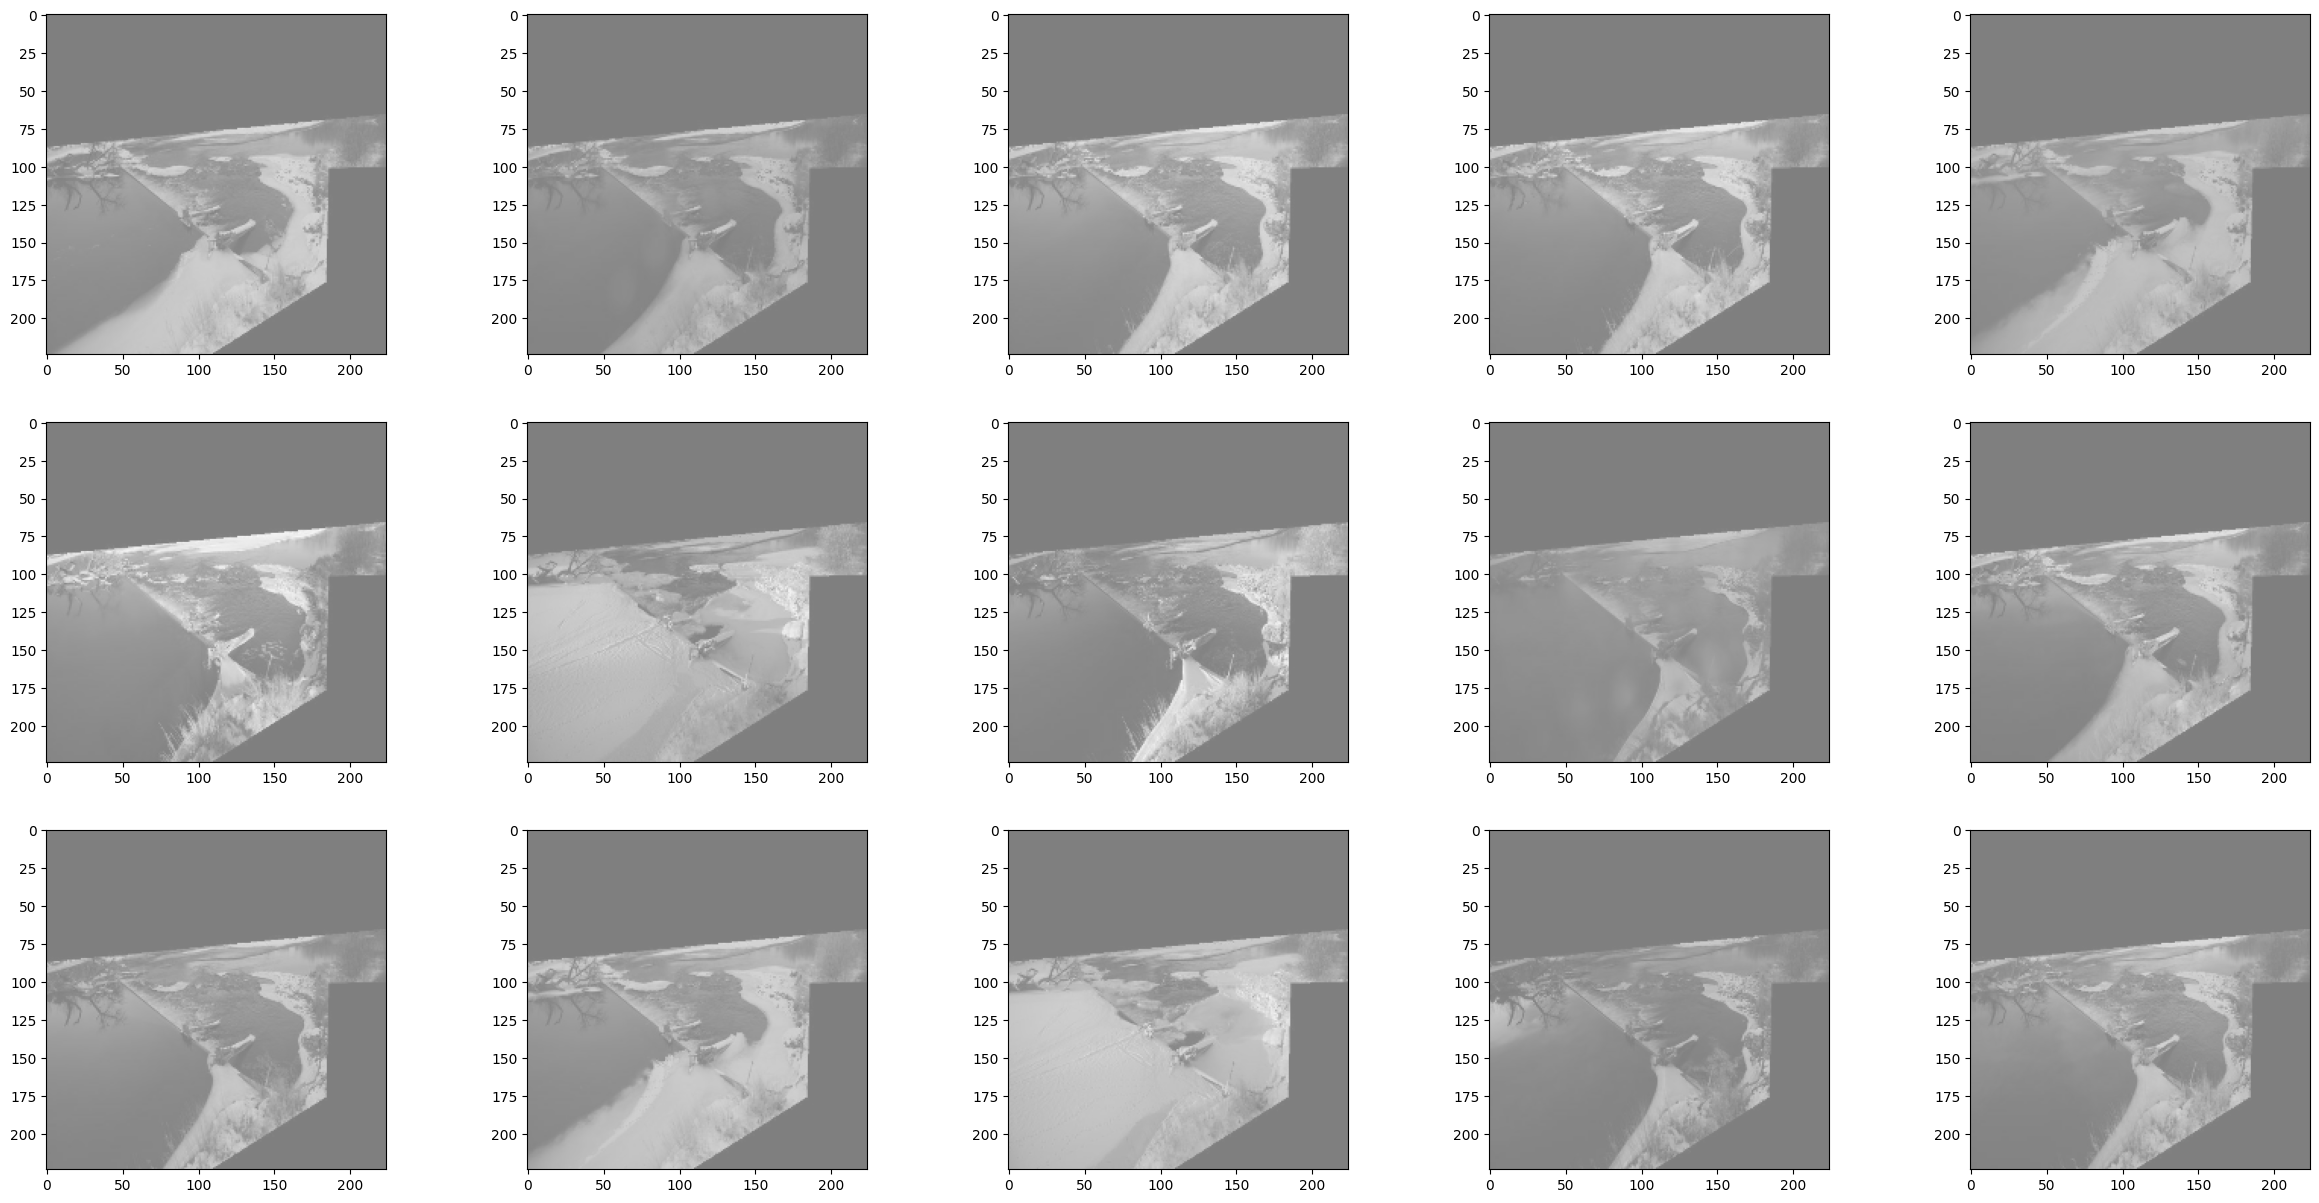

In [42]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))

for image, stage_discharge in test_ds.take(1):
    images = image[:15]
    for img, ax in zip(images, ax.flatten()):
        #img = img.numpy()[0]
        img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Create model

In [43]:
def create_model(input_shape, output_shape, option="normal"):
    model = Sequential()

    if option == "transfer":
        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)
        
        for layer in base_model.layers:
            layer.trainable = False

        base_model._name = 'base_model_ResNet50'

        model.add(base_model)
        model.add(Dropout(0.3))
        model.add(GlobalAveragePooling2D())

        model.add(Dense(1024, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(128, activation='elu'))
    elif option == "normal":
        model.add(Input(shape=input_shape))
        
        """model.add(Conv2D(16, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(4, 4), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(64, activation='elu'))"""

        model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', activation="elu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation="elu", padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same'))
        #model.add(AveragePooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='elu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(256, activation='tanh'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='tanh'))
        model.add(Dense(64, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
    elif option == "cnn/lstm":
        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                      weights='imagenet',
                                                      input_shape=(224, 224, 3))
        base_model.trainable = False
        base_model._name = 'base_model_ResNet50'
        model.add(Input(shape=input_shape))
        model.add(TimeDistributed(base_model))
        model.add(TimeDistributed(Dropout(0.3)))
        model.add(TimeDistributed(GlobalAveragePooling2D()))

        """model.add(Input(shape=input_shape))

        model.add(TimeDistributed(Conv2D(16, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='elu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation='elu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        

        model.add(TimeDistributed(Flatten()))"""

        model.add(LSTM(10, return_sequences=True))
        model.add(LSTM(15))

        model.add(Dense(512, activation='elu'))
        model.add(Dense(256, activation='elu'))
        model.add(Dense(128, activation='elu'))
        model.add(Dense(128, activation='elu'))
        
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [44]:
model = create_model(input_shape, output_shape[0], "transfer")

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_model_ResNet50 (Functi  (None, 7, 7, 2048)       23564800  
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)              

In [46]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [47]:
sgd = SGD(learning_rate=0.01, decay=1e-3, momentum=0.9, nesterov=True)
#adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

compile_model('mse', adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [48]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [49]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_cnn_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)


In [50]:
# batch_size = 0 because we already have batch size in tf dataset
with tf.device("/gpu:0"):
    model_h = fit_model(train_ds, val_ds, epochs=60, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, checkpoint_callback, es_callback])

Epoch 1/60
634/635 [============================>.] - ETA: 0s - loss: 0.5205 - mse: 0.5205 - rmse: 0.7215 - mae: 0.3409 - mape: 225.2428

2022-11-04 11:04:22.228276: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-04 11:04:22.229707: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


635/635 [==============================] - ETA: 0s - loss: 0.5202 - mse: 0.5202 - rmse: 0.7213 - mae: 0.3408 - mape: 225.1278

2022-11-04 11:04:45.310000: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-04 11:04:45.310603: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-04 11:04:46.296051: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141557760 exceeds 10% of free system memory.
2022-11-04 11:04:46.543720: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141557760 exceeds 10% of free system memory.
2022-11-04 11:04:46.705992: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1415


Epoch 1: val_loss improved from inf to 0.09488, saving model to model_weights/20221104-110316_cnn_best_weights.hdf5
635/635 [==============================] - 93s 141ms/step - loss: 0.5202 - mse: 0.5202 - rmse: 0.7213 - mae: 0.3408 - mape: 225.1278 - val_loss: 0.0949 - val_mse: 0.0949 - val_rmse: 0.3080 - val_mae: 0.2093 - val_mape: 91.6667
Epoch 2/60
635/635 [==============================] - ETA: 0s - loss: 0.0545 - mse: 0.0545 - rmse: 0.2335 - mae: 0.1611 - mape: 121.4101
Epoch 2: val_loss improved from 0.09488 to 0.07034, saving model to model_weights/20221104-110316_cnn_best_weights.hdf5
635/635 [==============================] - 85s 134ms/step - loss: 0.0545 - mse: 0.0545 - rmse: 0.2335 - mae: 0.1611 - mape: 121.4101 - val_loss: 0.0703 - val_mse: 0.0703 - val_rmse: 0.2652 - val_mae: 0.1739 - val_mape: 75.7995
Epoch 3/60
635/635 [==============================] - ETA: 0s - loss: 0.0350 - mse: 0.0350 - rmse: 0.1872 - mae: 0.1296 - mape: 97.6853
Epoch 3: val_loss improved from 0.07

## Evaluate model

In [51]:
print(date_actual)

20221104-110316


In [52]:
best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5')
#best_model = models.load_model(f'best_models_weights/cnn_best_weights_v9.hdf5')


In [53]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [54]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

397/398 [============================>.] - ETA: 0s - loss: 0.0742 - mse: 0.0742 - rmse: 0.2725 - mae: 0.1997 - mape: 103.9895

2022-11-04 11:27:26.655851: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-04 11:27:26.655893: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


398/398 [==============================] - 37s 92ms/step - loss: 0.0742 - mse: 0.0742 - rmse: 0.2724 - mae: 0.1997 - mape: 103.9765


In [55]:
#predictions = best_model.predict(test_ds, steps=np.ceil(test_size / BATCH_SIZE))

In [58]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge.numpy()
	predictions_values = predictions
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	stage_discharge_test_values = stage_discharge_test_values.numpy().reshape(10, 2)
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values)):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 34ms/step
30.236420682907294
5.3972539279432725
pred discharge: 477.4043884277344, actual discharge: 189.0
pred discharge: 444.8753967285156, actual discharge: 204.0
pred discharge: 440.7146911621094, actual discharge: 210.0000000000001
pred discharge: 651.461181640625, actual discharge: 208.9999999999999
pred discharge: 511.4961853027344, actual discharge: 192.9999999999999
pred discharge: 471.5941467285156, actual discharge: 192.9999999999999
pred discharge: 487.4829406738281, actual discharge: 192.9999999999999
pred discharge: 462.7614440917969, actual discharge: 192.9999999999999
pred discharge: 618.378662109375, actual discharge: 208.9999999999999
pred discharge: 424.4191589355469, actual discharge: 192.9999999999999


### Residual analysis

In [59]:
y_predictions = np.empty(shape=(1, 2)).astype('float32')
y_real = np.empty(shape=(1, 2)).astype('float32')

for image, stage_discharge in test_ds.take(100):
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge.numpy()))

1/1 [==============================] - 0s 26ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

0.21593582108796294


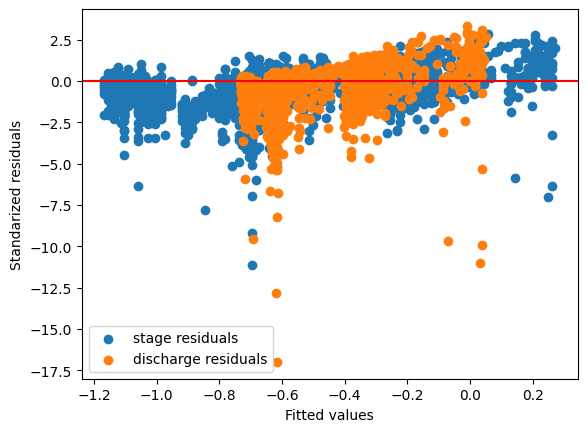

In [ ]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_real])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[1] for i in y_real])
residual_discharge = np.array([i[1] for i in residuals])

print(residual_stage.std())

plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

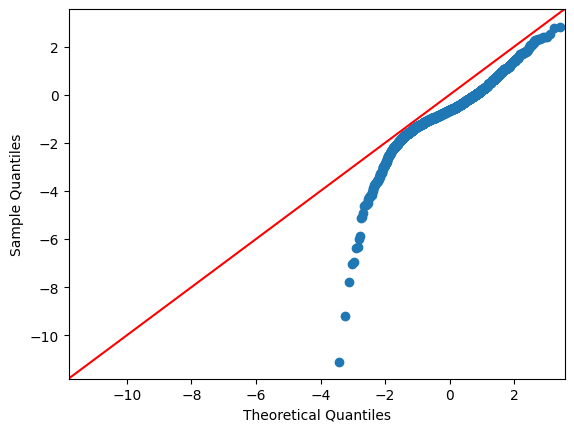

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

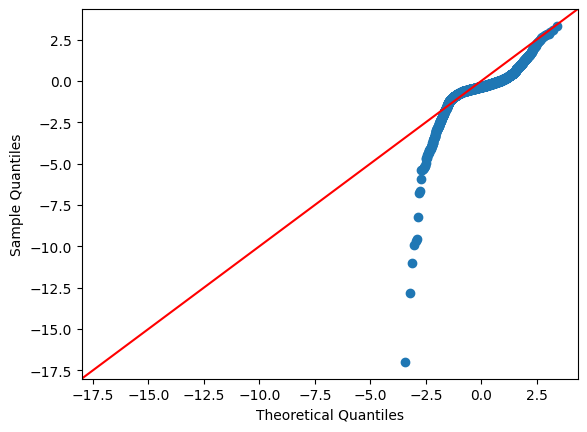

In [ ]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

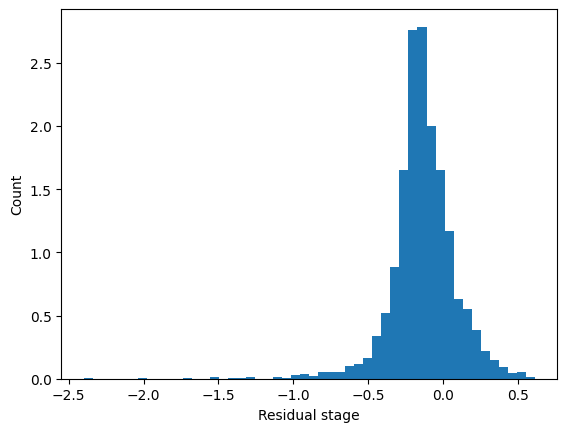

In [ ]:
plt.hist(residual_stage, density=True, bins = 50)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

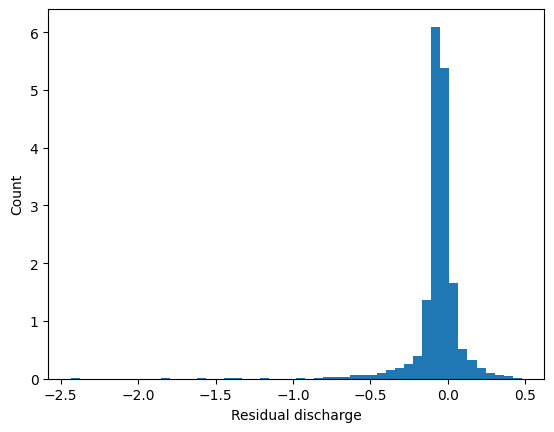

In [ ]:
plt.hist(residual_discharge, density=True, bins = 50)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [ ]:
stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")

p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


In [ ]:
stat, pval = normal_ad(residual_discharge)
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


## Visualize layers

In [ ]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [ ]:
activations = activation_model.predict(test_ds.take(1)) 

: 

In [ ]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

: 